In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, GlobalAveragePooling2D
import os
import cv2
import pickle
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model


from imblearn.under_sampling import RandomUnderSampler
from keras.utils.np_utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%load_ext tensorboard

In [2]:
dataPath = "../../data/OCT/OCT2017/"

In [3]:
labels_available = os.listdir(os.path.join(dataPath, "train"))
print("Total Number of Classes Detected :",len(labels_available))

labels_list = ['NORMAL',"CNV","DME","DRUSEN"]

Total Number of Classes Detected : 4


In [4]:
images=[]
y_trn=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "train", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        images.append(cv2.imread(os.path.join(xPath, y)))
        y_trn.append(labels_list.index(x))
    print(x ,end=" ")

y_train = to_categorical(y_trn,len(labels_list))

NORMAL CNV DME DRUSEN 

In [5]:
x_val=[]
y_val=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "val", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        x_val.append(cv2.imread(os.path.join(xPath, y)))
        y_val.append(labels_list.index(x))
    print(x ,end=" ")

y_validation = to_categorical(y_val,len(labels_list))

NORMAL CNV DME DRUSEN 

In [6]:
x_tst=[]
y_tst=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "test", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        x_tst.append(cv2.imread(os.path.join(xPath, y)))
        y_tst.append(labels_list.index(x))
    print(x ,end=" ")

NORMAL CNV DME DRUSEN 

In [65]:
def resizeIm(im, size):
    if im.shape[2] == 1:
        im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    return cv2.resize(im, size)

def resizeIms(x, size):
    return np.array(list(map(lambda im: resizeIm(im, size), x)))

In [66]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self,fraction, model):
        super(CustomCallback,self).__init__()
        self.fraction = fraction
        self.train_a = [];
        self.val_a =[];
        self.logPath = os.path.join(model, "log.txt")

        if not os.path.isdir(model):
            os.mkdir(model)

        with open(self.logPath,'w') as f:
            f.write('Starting of logging..\n')

        self.fig = plt.figure(figsize=(4,3))
        self.ax = plt.subplot(1,1,1)
        plt.ion()

    def on_train_begin(self,logs=None):
        self.fig.show()
        self.fig.canvas.draw()

    def on_train_end(self,logs=None):
        with open(self.logPath,'a') as f:
              f.write('End of logging..\n')
    
    def on_epoch_begin(self,epoch,logs=None):
        lr= tf.keras.backend.get_value(self.model.optimizer.lr)
        lr *= self.fraction
        tf.keras.backend.set_value(self.model.optimizer.lr,lr)
        with open(self.logPath,'a') as f:
            f.write('At epoch {:02d}, learning rate changed to {:.4f}\n'.format(epoch,lr))
    
    def on_epoch_end(self,epoch,logs=None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        self.train_a.append(train_acc)
        self.val_a.append(val_acc)
        with open(self.logPath,'a') as f:
            f.write('At epoch {:02d}, training accuracy: {:.3f}, validation accuracy: {:.3f}\n'.format(epoch,train_acc,val_acc))
        self.ax.clear()
        self.ax.plot(range(1+epoch),self.train_a,label="Training")
        self.ax.plot(range(1+epoch),self.val_a,label="Validation")
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('Accuracy')
        self.ax.legend()
        self.fig.canvas.draw()
        self.fig.show()

## Load models

In [67]:
# xception base model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
xceptionNetModel = Xception(weights='imagenet')

# opticnet base model
opticNetModel = tf.keras.models.load_model('../Optic_net-4_classes-Kermany2018.hdf5')

# resnet base model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

resNetModel = ResNet50(weights='imagenet')

In [68]:
def emptyModelGenerator(model):
    model = model.lower()
    if model == "resnet":
        x = resNetModel.output
        predictions = Dense(len(labels_list), activation='softmax')(x)
        newModel = Model(inputs=resNetModel.input, outputs=predictions)
        size = (224, 224)
    elif model == "xception":
        x = xceptionNetModel.output
        predictions = Dense(len(labels_list), activation='softmax')(x)
        newModel = Model(inputs=xceptionNetModel.input, outputs=predictions)
        size = (299, 299)
    elif model == "opticnet":
        newModel = tf.keras.models.load_model('../Optic_net-4_classes-Kermany2018.hdf5')
        size = (224, 224)
    return newModel, size


def testPredict(model, size, name=None):
    X_test = resizeIms(x_tst, size)
    X_test = np.array(X_test)
    Y_test = np.array(y_tst)
    
    prediction = model.predict(X_test)
    preds = np.argmax(prediction, axis=1)
    acc = sum(preds == Y_test) / len(Y_test)
    print(f'Test acc for {name if name else "model"}: {acc:.6f}')
    

def computeConfussionMatrix(predictions, labels):
    num_labels = len(labels_list)
    cMatrix = np.zeros(shape=(num_labels, num_labels))
    for i in len(predictions):
        p = int(predictions[i])
        t = int(predictions[i])
        cMatrix[t, p] += 1
    print(cMatrix)
    ax = sns.heatmap(cMatrix, cmap="Blues", annot=True, fmt="d", xticklabels=labels_list, yticklabels=labels_list)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion matrix")
    plt.show();
    return cMatrix
    


In [69]:
optim = Adam(learning_rate=0.001)
epochs = 30
batch_size = 50

Labels fraction: [0.01037431 0.00938046 0.01092704 0.01021356]
Training xception for 0.01% of train size (aka 834 images)...


<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
17/17 [==============================] - 23s 1s/step - loss: 1.4028 - accuracy: 0.0087 - val_loss: 1.3976 - val_accuracy: 0.2500


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
17/17 [==============================] - 12s 725ms/step - loss: 1.3682 - accuracy: 0.6616 - val_loss: 1.3709 - val_accuracy: 0.5000
Epoch 3/30
17/17 [==============================] - 12s 727ms/step - loss: 1.3425 - accuracy: 0.7302 - val_loss: 1.3718 - val_accuracy: 0.3438
Epoch 4/30
17/17 [==============================] - 12s 730ms/step - loss: 1.3234 - accuracy: 0.7447 - val_loss: 1.3642 - val_accuracy: 0.2500
Epoch 5/30
17/17 [==============================] - 13s 737ms/step - loss: 1.3059 - accuracy: 0.7277 - val_loss: 1.3520 - val_accuracy: 0.3438
Epoch 6/30
17/17 [==============================] - 13s 749ms/step - loss: 1.2875 - accuracy: 0.7606 - val_loss: 1.3576 - val_accuracy: 0.2812
Epoch 7/30
17/17 [==============================] - 13s 748ms/step - loss: 1.2777 - accuracy: 0.7483 - val_loss: 1.3609 - val_accuracy: 0.2812
Epoch 8/30
17/17 [==============================] - 13s 756ms/step - loss: 1.2656 - accuracy: 0.7554 - val_loss: 1.3457 - val_accuracy: 0.4062

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
17/17 [==============================] - 16s 490ms/step - loss: 1.3341 - accuracy: 0.9014 - val_loss: 1.3254 - val_accuracy: 0.9688


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
17/17 [==============================] - 3s 196ms/step - loss: 1.3081 - accuracy: 0.9921 - val_loss: 1.3115 - val_accuracy: 0.9375
Epoch 3/30
17/17 [==============================] - 3s 196ms/step - loss: 1.2846 - accuracy: 0.9960 - val_loss: 1.2936 - val_accuracy: 0.9375
Epoch 4/30
17/17 [==============================] - 3s 196ms/step - loss: 1.2635 - accuracy: 0.9897 - val_loss: 1.2788 - val_accuracy: 0.9375
Epoch 5/30
17/17 [==============================] - 3s 197ms/step - loss: 1.2437 - accuracy: 0.9960 - val_loss: 1.2580 - val_accuracy: 0.9688
Epoch 6/30
17/17 [==============================] - 3s 197ms/step - loss: 1.2315 - accuracy: 0.9884 - val_loss: 1.2523 - val_accuracy: 0.9688
Epoch 7/30
17/17 [==============================] - 3s 197ms/step - loss: 1.2128 - accuracy: 0.9934 - val_loss: 1.2418 - val_accuracy: 0.9688
Epoch 8/30
17/17 [==============================] - 3s 197ms/step - loss: 1.2021 - accuracy: 0.9924 - val_loss: 1.2328 - val_accuracy: 0.9688
Epoch 

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
17/17 [==============================] - 39s 2s/step - loss: 3.2698 - accuracy: 0.3753 - val_loss: 40.6838 - val_accuracy: 0.2500


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
17/17 [==============================] - 20s 1s/step - loss: 0.5878 - accuracy: 0.7872 - val_loss: 62.4663 - val_accuracy: 0.2500
Epoch 3/30
17/17 [==============================] - 20s 1s/step - loss: 0.3097 - accuracy: 0.8914 - val_loss: 3.2088 - val_accuracy: 0.4688
Epoch 4/30
17/17 [==============================] - 20s 1s/step - loss: 0.1631 - accuracy: 0.9310 - val_loss: 2.3973 - val_accuracy: 0.4688
Epoch 5/30
17/17 [==============================] - 20s 1s/step - loss: 0.1017 - accuracy: 0.9646 - val_loss: 1.0963 - val_accuracy: 0.7188
Epoch 6/30
17/17 [==============================] - 20s 1s/step - loss: 0.0457 - accuracy: 0.9900 - val_loss: 0.5293 - val_accuracy: 0.9375
Epoch 7/30
17/17 [==============================] - 20s 1s/step - loss: 0.0744 - accuracy: 0.9758 - val_loss: 0.4955 - val_accuracy: 0.9375
Epoch 8/30
17/17 [==============================] - 20s 1s/step - loss: 0.0472 - accuracy: 0.9854 - val_loss: 0.1893 - val_accuracy: 0.8750
Epoch 9/30
17/17 [=

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
42/42 [==============================] - 42s 862ms/step - loss: 1.3743 - accuracy: 0.1585 - val_loss: 1.3476 - val_accuracy: 0.5000


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
42/42 [==============================] - 32s 756ms/step - loss: 1.3206 - accuracy: 0.7604 - val_loss: 1.3285 - val_accuracy: 0.5000
Epoch 3/30
42/42 [==============================] - 32s 759ms/step - loss: 1.2799 - accuracy: 0.7481 - val_loss: 1.3129 - val_accuracy: 0.5000
Epoch 4/30
42/42 [==============================] - 32s 759ms/step - loss: 1.2405 - accuracy: 0.7580 - val_loss: 1.2992 - val_accuracy: 0.5000
Epoch 5/30
42/42 [==============================] - 32s 762ms/step - loss: 1.2155 - accuracy: 0.7394 - val_loss: 1.2826 - val_accuracy: 0.5000
Epoch 6/30
42/42 [==============================] - 32s 761ms/step - loss: 1.1872 - accuracy: 0.7477 - val_loss: 1.2723 - val_accuracy: 0.5000
Epoch 7/30
42/42 [==============================] - 32s 763ms/step - loss: 1.1590 - accuracy: 0.7607 - val_loss: 1.2669 - val_accuracy: 0.5000
Epoch 8/30
42/42 [==============================] - 32s 759ms/step - loss: 1.1430 - accuracy: 0.7524 - val_loss: 1.2619 - val_accuracy: 0.5000

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
42/42 [==============================] - 19s 307ms/step - loss: 1.3517 - accuracy: 0.7322 - val_loss: 1.3233 - val_accuracy: 0.7500


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
42/42 [==============================] - 8s 196ms/step - loss: 1.2860 - accuracy: 0.8612 - val_loss: 1.2868 - val_accuracy: 0.6250
Epoch 3/30
42/42 [==============================] - 8s 197ms/step - loss: 1.2304 - accuracy: 0.8589 - val_loss: 1.2570 - val_accuracy: 0.8750
Epoch 4/30
42/42 [==============================] - 8s 197ms/step - loss: 1.1840 - accuracy: 0.9806 - val_loss: 1.2032 - val_accuracy: 1.0000
Epoch 5/30
42/42 [==============================] - 8s 198ms/step - loss: 1.1361 - accuracy: 0.9944 - val_loss: 1.1720 - val_accuracy: 1.0000
Epoch 6/30
42/42 [==============================] - 8s 198ms/step - loss: 1.1023 - accuracy: 0.9957 - val_loss: 1.1697 - val_accuracy: 0.9375
Epoch 7/30
42/42 [==============================] - 8s 198ms/step - loss: 1.0723 - accuracy: 0.9932 - val_loss: 1.1242 - val_accuracy: 0.9688
Epoch 8/30
42/42 [==============================] - 8s 198ms/step - loss: 1.0410 - accuracy: 0.9920 - val_loss: 1.1022 - val_accuracy: 1.0000
Epoch 

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
42/42 [==============================] - 68s 1s/step - loss: 1.9885 - accuracy: 0.5826 - val_loss: 1.4458 - val_accuracy: 0.5625


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
42/42 [==============================] - 49s 1s/step - loss: 0.2677 - accuracy: 0.9046 - val_loss: 0.3291 - val_accuracy: 0.8438
Epoch 3/30
42/42 [==============================] - 49s 1s/step - loss: 0.1004 - accuracy: 0.9678 - val_loss: 0.3266 - val_accuracy: 0.8438
Epoch 4/30
42/42 [==============================] - 49s 1s/step - loss: 0.0668 - accuracy: 0.9772 - val_loss: 0.0773 - val_accuracy: 0.9688
Epoch 5/30
42/42 [==============================] - 49s 1s/step - loss: 0.0363 - accuracy: 0.9885 - val_loss: 0.0943 - val_accuracy: 0.9688
Epoch 6/30
42/42 [==============================] - 50s 1s/step - loss: 0.0464 - accuracy: 0.9869 - val_loss: 0.0239 - val_accuracy: 1.0000
Epoch 7/30
42/42 [==============================] - 49s 1s/step - loss: 0.0227 - accuracy: 0.9935 - val_loss: 0.0594 - val_accuracy: 0.9688
Epoch 8/30
42/42 [==============================] - 49s 1s/step - loss: 0.0225 - accuracy: 0.9915 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 9/30
42/42 [==

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
84/84 [==============================] - 73s 805ms/step - loss: 1.3580 - accuracy: 0.4712 - val_loss: 1.3066 - val_accuracy: 0.7188


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
84/84 [==============================] - 63s 753ms/step - loss: 1.2509 - accuracy: 0.8437 - val_loss: 1.2448 - val_accuracy: 0.7500
Epoch 3/30
84/84 [==============================] - 63s 755ms/step - loss: 1.1646 - accuracy: 0.8452 - val_loss: 1.1968 - val_accuracy: 0.7500
Epoch 4/30
84/84 [==============================] - 63s 755ms/step - loss: 1.0949 - accuracy: 0.8553 - val_loss: 1.1929 - val_accuracy: 0.6875
Epoch 5/30
84/84 [==============================] - 63s 754ms/step - loss: 1.0360 - accuracy: 0.8576 - val_loss: 1.1495 - val_accuracy: 0.6875
Epoch 6/30
84/84 [==============================] - 63s 756ms/step - loss: 0.9981 - accuracy: 0.8482 - val_loss: 1.0957 - val_accuracy: 0.7500
Epoch 7/30
84/84 [==============================] - 63s 755ms/step - loss: 0.9552 - accuracy: 0.8587 - val_loss: 1.0867 - val_accuracy: 0.7188
Epoch 8/30
84/84 [==============================] - 63s 755ms/step - loss: 0.9159 - accuracy: 0.8607 - val_loss: 1.0502 - val_accuracy: 0.7500

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
84/84 [==============================] - 29s 250ms/step - loss: 1.3544 - accuracy: 0.3608 - val_loss: 1.3306 - val_accuracy: 0.5312


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
84/84 [==============================] - 17s 196ms/step - loss: 1.2313 - accuracy: 0.8991 - val_loss: 1.2072 - val_accuracy: 0.9688
Epoch 3/30
84/84 [==============================] - 17s 197ms/step - loss: 1.1297 - accuracy: 0.9700 - val_loss: 1.1285 - val_accuracy: 1.0000
Epoch 4/30
84/84 [==============================] - 17s 198ms/step - loss: 1.0393 - accuracy: 0.9842 - val_loss: 1.1161 - val_accuracy: 0.8750
Epoch 5/30
84/84 [==============================] - 17s 198ms/step - loss: 0.9722 - accuracy: 0.9827 - val_loss: 1.0387 - val_accuracy: 0.9375
Epoch 6/30
84/84 [==============================] - 17s 198ms/step - loss: 0.9132 - accuracy: 0.9825 - val_loss: 0.9838 - val_accuracy: 0.9688
Epoch 7/30
84/84 [==============================] - 17s 198ms/step - loss: 0.8689 - accuracy: 0.9809 - val_loss: 1.0155 - val_accuracy: 0.8750
Epoch 8/30
84/84 [==============================] - 17s 198ms/step - loss: 0.8180 - accuracy: 0.9912 - val_loss: 0.9487 - val_accuracy: 0.9375

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
84/84 [==============================] - 117s 1s/step - loss: 1.3640 - accuracy: 0.6885 - val_loss: 0.2421 - val_accuracy: 0.9062


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
84/84 [==============================] - 99s 1s/step - loss: 0.1705 - accuracy: 0.9464 - val_loss: 0.2397 - val_accuracy: 0.9688
Epoch 3/30
84/84 [==============================] - 99s 1s/step - loss: 0.1359 - accuracy: 0.9590 - val_loss: 0.1144 - val_accuracy: 0.9688
Epoch 4/30
84/84 [==============================] - 99s 1s/step - loss: 0.0792 - accuracy: 0.9752 - val_loss: 0.0140 - val_accuracy: 1.0000
Epoch 5/30
84/84 [==============================] - 99s 1s/step - loss: 0.0682 - accuracy: 0.9733 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 6/30
84/84 [==============================] - 99s 1s/step - loss: 0.0325 - accuracy: 0.9885 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 7/30
84/84 [==============================] - 99s 1s/step - loss: 0.0091 - accuracy: 0.9971 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 8/30
84/84 [==============================] - 98s 1s/step - loss: 0.0434 - accuracy: 0.9846 - val_loss: 2.5282e-04 - val_accuracy: 1.0000
Epoch 9/30
84/84

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
126/126 [==============================] - 105s 792ms/step - loss: 1.3416 - accuracy: 0.5114 - val_loss: 1.2820 - val_accuracy: 0.7188


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
126/126 [==============================] - 97s 771ms/step - loss: 1.1847 - accuracy: 0.8480 - val_loss: 1.2028 - val_accuracy: 0.7188
Epoch 3/30
126/126 [==============================] - 97s 772ms/step - loss: 1.0729 - accuracy: 0.8441 - val_loss: 1.1517 - val_accuracy: 0.7188
Epoch 4/30
126/126 [==============================] - 97s 772ms/step - loss: 0.9866 - accuracy: 0.8461 - val_loss: 1.0790 - val_accuracy: 0.7500
Epoch 5/30
126/126 [==============================] - 97s 770ms/step - loss: 0.9120 - accuracy: 0.8591 - val_loss: 1.0355 - val_accuracy: 0.7500
Epoch 6/30
126/126 [==============================] - 97s 771ms/step - loss: 0.8697 - accuracy: 0.8481 - val_loss: 1.0001 - val_accuracy: 0.7500
Epoch 7/30
126/126 [==============================] - 97s 770ms/step - loss: 0.8229 - accuracy: 0.8535 - val_loss: 0.9699 - val_accuracy: 0.7500
Epoch 8/30
126/126 [==============================] - 97s 770ms/step - loss: 0.7833 - accuracy: 0.8600 - val_loss: 0.9439 - val_ac

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
126/126 [==============================] - 35s 229ms/step - loss: 1.3380 - accuracy: 0.4202 - val_loss: 1.2462 - val_accuracy: 0.5000


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
126/126 [==============================] - 25s 198ms/step - loss: 1.1576 - accuracy: 0.8066 - val_loss: 1.1377 - val_accuracy: 0.9688
Epoch 3/30
126/126 [==============================] - 25s 199ms/step - loss: 1.0177 - accuracy: 0.9773 - val_loss: 1.0300 - val_accuracy: 1.0000
Epoch 4/30
126/126 [==============================] - 25s 199ms/step - loss: 0.9119 - accuracy: 0.9757 - val_loss: 0.9740 - val_accuracy: 0.9688
Epoch 5/30
126/126 [==============================] - 25s 199ms/step - loss: 0.8289 - accuracy: 0.9772 - val_loss: 0.9796 - val_accuracy: 0.8750
Epoch 6/30
126/126 [==============================] - 25s 199ms/step - loss: 0.7594 - accuracy: 0.9784 - val_loss: 0.8266 - val_accuracy: 1.0000
Epoch 7/30
126/126 [==============================] - 25s 199ms/step - loss: 0.7044 - accuracy: 0.9811 - val_loss: 0.7782 - val_accuracy: 1.0000
Epoch 8/30
126/126 [==============================] - 25s 199ms/step - loss: 0.6611 - accuracy: 0.9816 - val_loss: 0.7367 - val_ac

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
126/126 [==============================] - 167s 1s/step - loss: 1.1032 - accuracy: 0.7386 - val_loss: 0.5010 - val_accuracy: 0.8438


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
126/126 [==============================] - 148s 1s/step - loss: 0.1493 - accuracy: 0.9481 - val_loss: 0.0634 - val_accuracy: 1.0000
Epoch 3/30
126/126 [==============================] - 148s 1s/step - loss: 0.1172 - accuracy: 0.9632 - val_loss: 0.0613 - val_accuracy: 1.0000
Epoch 4/30
126/126 [==============================] - 147s 1s/step - loss: 0.0818 - accuracy: 0.9734 - val_loss: 0.0373 - val_accuracy: 1.0000
Epoch 5/30
126/126 [==============================] - 147s 1s/step - loss: 0.0858 - accuracy: 0.9728 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 6/30
126/126 [==============================] - 148s 1s/step - loss: 0.0603 - accuracy: 0.9795 - val_loss: 0.0195 - val_accuracy: 1.0000
Epoch 7/30
126/126 [==============================] - 148s 1s/step - loss: 0.0261 - accuracy: 0.9899 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 8/30
126/126 [==============================] - 148s 1s/step - loss: 0.0269 - accuracy: 0.9912 - val_loss: 4.7792e-04 - val_accuracy: 1.

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
151/151 [==============================] - 130s 815ms/step - loss: 1.3128 - accuracy: 0.7612 - val_loss: 1.2521 - val_accuracy: 0.5000


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
151/151 [==============================] - 122s 807ms/step - loss: 1.1318 - accuracy: 0.7664 - val_loss: 1.2350 - val_accuracy: 0.6250
Epoch 3/30
151/151 [==============================] - 120s 795ms/step - loss: 1.0152 - accuracy: 0.8516 - val_loss: 1.0936 - val_accuracy: 0.7500
Epoch 4/30
151/151 [==============================] - 121s 799ms/step - loss: 0.9189 - accuracy: 0.8543 - val_loss: 1.0375 - val_accuracy: 0.7500
Epoch 5/30
151/151 [==============================] - 120s 793ms/step - loss: 0.8515 - accuracy: 0.8557 - val_loss: 0.9902 - val_accuracy: 0.7500
Epoch 6/30
151/151 [==============================] - 120s 792ms/step - loss: 0.8011 - accuracy: 0.8589 - val_loss: 0.9523 - val_accuracy: 0.7500
Epoch 7/30
151/151 [==============================] - 121s 804ms/step - loss: 0.7440 - accuracy: 0.8653 - val_loss: 0.7828 - val_accuracy: 1.0000
Epoch 8/30
151/151 [==============================] - 120s 797ms/step - loss: 0.6281 - accuracy: 0.9742 - val_loss: 0.6579 -

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
151/151 [==============================] - 40s 224ms/step - loss: 1.3233 - accuracy: 0.6277 - val_loss: 1.2626 - val_accuracy: 0.5000


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
151/151 [==============================] - 30s 197ms/step - loss: 1.1080 - accuracy: 0.7778 - val_loss: 1.1361 - val_accuracy: 0.9062
Epoch 3/30
151/151 [==============================] - 30s 198ms/step - loss: 0.9516 - accuracy: 0.9726 - val_loss: 1.1606 - val_accuracy: 0.7500
Epoch 4/30
151/151 [==============================] - 30s 198ms/step - loss: 0.8388 - accuracy: 0.9711 - val_loss: 0.8818 - val_accuracy: 1.0000
Epoch 5/30
151/151 [==============================] - 30s 198ms/step - loss: 0.7428 - accuracy: 0.9846 - val_loss: 0.9592 - val_accuracy: 0.8125
Epoch 6/30
151/151 [==============================] - 30s 198ms/step - loss: 0.6733 - accuracy: 0.9828 - val_loss: 0.8210 - val_accuracy: 0.9375
Epoch 7/30
151/151 [==============================] - 30s 199ms/step - loss: 0.6128 - accuracy: 0.9835 - val_loss: 0.6899 - val_accuracy: 1.0000
Epoch 8/30
151/151 [==============================] - 30s 198ms/step - loss: 0.5619 - accuracy: 0.9885 - val_loss: 0.6450 - val_ac

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
151/151 [==============================] - 197s 1s/step - loss: 1.0461 - accuracy: 0.7215 - val_loss: 0.1278 - val_accuracy: 0.9688


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
151/151 [==============================] - 177s 1s/step - loss: 0.1351 - accuracy: 0.9537 - val_loss: 0.0564 - val_accuracy: 1.0000
Epoch 3/30
151/151 [==============================] - 177s 1s/step - loss: 0.1023 - accuracy: 0.9658 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 4/30
151/151 [==============================] - 177s 1s/step - loss: 0.0832 - accuracy: 0.9752 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 5/30
151/151 [==============================] - 177s 1s/step - loss: 0.0556 - accuracy: 0.9827 - val_loss: 0.0443 - val_accuracy: 0.9688
Epoch 6/30
151/151 [==============================] - 177s 1s/step - loss: 0.0489 - accuracy: 0.9828 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 7/30
151/151 [==============================] - 177s 1s/step - loss: 0.0269 - accuracy: 0.9929 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 8/30
151/151 [==============================] - 177s 1s/step - loss: 0.0136 - accuracy: 0.9963 - val_loss: 0.0341 - val_accuracy: 0.9688

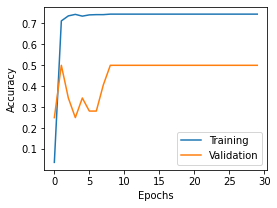

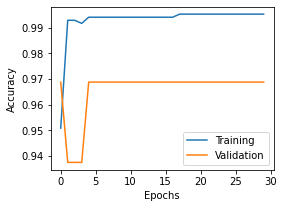

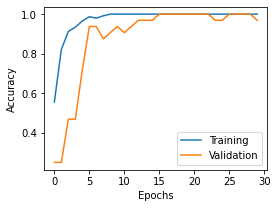

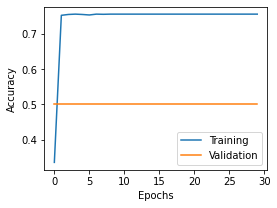

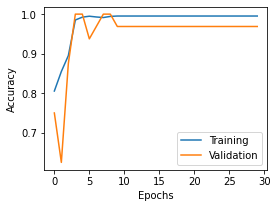

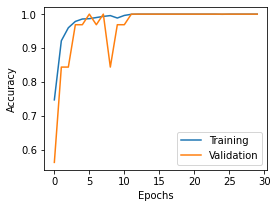

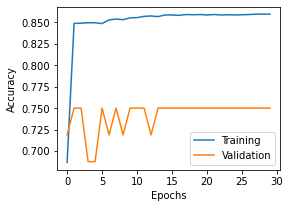

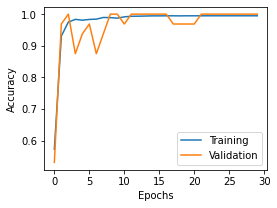

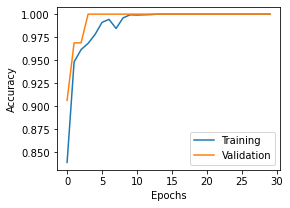

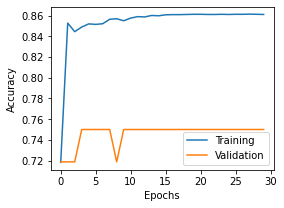

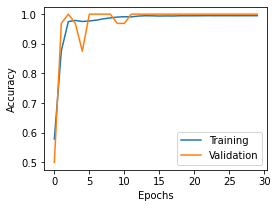

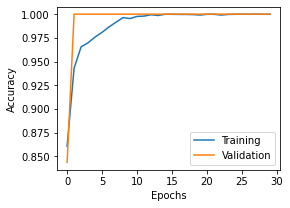

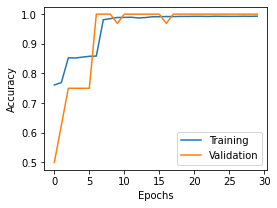

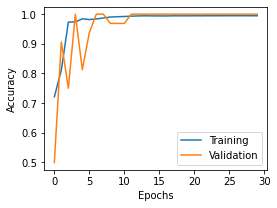

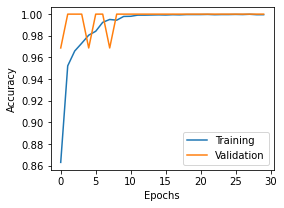

In [72]:
from sklearn.model_selection import train_test_split
import datetime

maxTrain = len(y_train)
#for p in [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9]:
for p in [0.01, 0.025, 0.05, 0.075, 0.09]:
    #X_trn, X_tst, y_trn, y_tst
    X_t, _, y_t, _ = train_test_split(images, y_train, test_size=1-p, random_state=123)
    print(f"Labels fraction: {sum(y_t == 1) / sum(y_train == 1)}")
    for net in ["xception", "resnet", "opticnet"]:
        print(f"Training {net} for {p}% of train size (aka {len(X_t)} images)...")
        model, size = emptyModelGenerator(net)
        X_trn = resizeIms(X_t, size)
        X_val = resizeIms(x_val, size)
        log_dir = f"logs/{net}/fit/{p}trainSet_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        optim = Adam(learning_rate=0.001)
        model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(X_trn, y_t, epochs=epochs, validation_data = (X_val, y_validation), batch_size=batch_size,
                    shuffle=True, max_queue_size=20,
                    use_multiprocessing=True, workers=5, 
                    callbacks=[CustomCallback(fraction=0.9, model=net), tensorboard_callback])
        model.save(f"../{net}/{net}_{epochs}epochs_{p*maxTrain} images")
        testPredict(model, size, name=net)
        del model
        del X_trn
        del X_val
        print("Done!\n" + '-'*50, end='\n\n')